本项目包含吴恩达机器学习的ex1的python实现，参考url: https://www.heywhale.com/mw/project/5da16a37037db3002d441810

主要是为了对机器学习算法进行一个小练习。

# ex1: 线性回归

代码使用的是 numpy实现，我争取使用pytorch进行实现

In [556]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from numpy.linalg import inv
import torch 

# 1. 简单练习

输出一个5*5的单位矩阵


In [557]:
A = np.eye(5)
print(A)
B = torch.eye(5)
print(B)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])


# 2 单变量的线性回归
整个2的部门需要根据城市人口数量，预测开小吃店的利润
数据在ex1data1.txt里面，第一列是城市人口数量，第二列是该城市小吃店利润。



## 2.1 Plotting the Data
读入数据，然后展示数据

In [558]:
path = './Andrew-NG-Meachine-Learning/machine-learning-ex1/ex1/ex1data1.txt'
data = pd.read_csv(path, header=None, names=['Population', 'Profit'])
data.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


Text(0.5, 1.0, 'test')

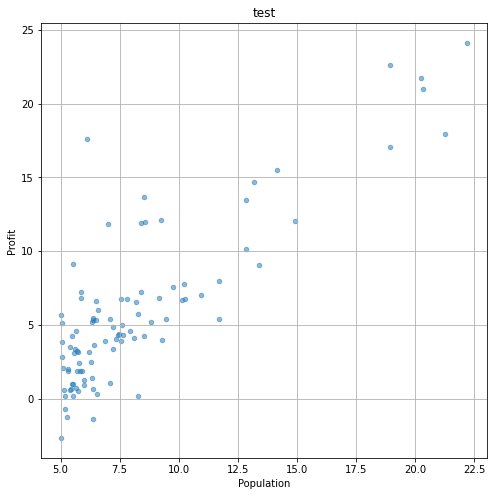

In [559]:
fig, axs = plt.subplots(figsize=(8, 8))
data.plot.scatter(x='Population', y='Profit', alpha = 0.5, ax = axs)
x_label = [i for i in data['Population']]
axs.grid()
axs.set_title("test")

In [560]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Population  97 non-null     float64
 1   Profit      97 non-null     float64
dtypes: float64(2)
memory usage: 1.6 KB


## 2.2 梯度下降
### 2.2.1 线性回归损失函数公式
$$
    (x^{(i)}, y^{(i)}) = (x_1^{(i)}, x_2^{(i)},..., x_n^{(i)}, y^{(i)})
$$
$$
    h_\theta(x^{(i)}) = \theta_0 + \theta_1x_1^{(i)} + \theta_2x_2^{(i)} + ... + \theta_nx_n^{(i)} = \theta^Tx^{(i)}
$$
一共有M组样例
$$
    J(\theta) = \frac{1}{2m}\sum_{i=1}^m\left(h_\theta(x^{(i)}) - y^{(i)}\right)^2
$$
对该公式进行向量化
$$
    X * \theta = \left[\begin{matrix}
        x_0^{(1)} & x_1^{(1)} & x_2^{(1)} &... & x_n^{(1)} \\ 
        x_0^{(2)} & x_1^{(2)} & x_2^{(2)} &... & x_n^{(2)}      \\
              \\
        x_0^{(m)} & x_1^{(m)} & x_2^{(m)} &... & x_n^{(m)} \\
     \end{matrix} \right] * 
     \left[\begin{matrix}
       \theta_0              \\
       \theta_1                      \\
        ...              \\
       \theta_n              \\
      \end{matrix} \right] = 
      \left[\begin{matrix} 
        \theta_0 + \theta_1x_1^{(1)} + \theta_2x_2^{(1)} + ... + \theta_nx_n^{(1)} = \theta^Tx^{(1)}   & \\
        \theta_0 + \theta_1x_1^{(2)} + \theta_2x_2^{(2)} + ... + \theta_nx_n^{(2)} = \theta^Tx^{(2)}   & \\
        ... &  \\
        \theta_0 + \theta_1x_1^{(m)} + \theta_2x_2^{(m)} + ... + \theta_nx_n^{(m)} = \theta^Tx^{m)  \\
        
        
        
        }                              \\
          \end{matrix} \right]
$$

 

In [561]:
# 根据我上面推的公式 X.shape=(m, n), theta
def computeCost(X, y, theta):
    """ 
    X.shape = (m, n)
    y.shape = (m , 1)
    theta.shape = (n, 1)
    """
    inner = np.power(np.dot(X, theta) - y, 2)
    return np.sum(inner) / (2 * len(X))
    
print(computeCost(np.arange(1, 10).reshape(3, 3), np.arange(1, 4).reshape(3, 1), np.arange(1, 4)))

def computeCost2(X, y, theta):
    res = 0
    for i in range(len(X)):
        tmp =  np.dot(X[i], theta) - y[i] 
        res += tmp * tmp
    return res / (2 * len(X))
print(computeCost2(np.arange(1, 10).reshape(3, 3), np.arange(1, 4).reshape(3, 1), np.arange(1, 4)))

1675.0
[546.33333333]


### 2.2.2 实现
数据前面已经读取完毕，我们要加入一列x,用于更新theta0，然后将theta数组初始化为0，学习率初始化为0.01，迭代次数为1500次

In [562]:
data.insert(0, 'Ones', 1)
data = data[['Ones', 'Population', 'Profit']]
data

,Ones,Population,Profit
0,1,6.1101,17.59200
1,1,5.5277,9.13020
2,1,8.5186,13.66200
3,1,7.0032,11.85400
4,1,5.8598,6.82330
...,...,...,...
92,1,5.8707,7.20290
93,1,5.3054,1.98690
94,1,8.2934,0.14454
95,1,13.3940,9.05510


现在初始化变量

cols: 列

X：前两列['Ones', 'Population']

y: 最后一列['Profit']

In [563]:
cols = data.shape[1]
X = data.iloc[:,:-1]
print(X.head())
y = data.iloc[:, -1:cols]
print(y.head())

   Ones  Population
0     1      6.1101
1     1      5.5277
2     1      8.5186
3     1      7.0032
4     1      5.8598
    Profit
0  17.5920
1   9.1302
2  13.6620
3  11.8540
4   6.8233


Cost function is a numpy matrix

So, we need transfer X and y, then we can use it.

And, we should initialize theta

In [564]:
X = np.array(X)
y = np.array(y)
theta = np.zeros(2).reshape(2, 1)
X.shape, theta.shape, y.shape

((97, 2), (2, 1), (97, 1))

### 2.2.3 计算 $J(\theta)$
计算代价函数 $J(\theta)$， $\theta$的初始值为[[0,0]], 答案应该为23.07。

In [565]:
computeCost(X, y, theta)

32.072733877455676

### 2.2.4 梯度下降

记住$J(\theta)$的变量是$tehta$, 而不是X和y。我们变化的值来使得 $J(\theta)$变化，而不是变化X和y的值。

一个检查梯度下降是不是在正常运作的方式，是打印每一步 $J(\theta)$的值，看它是不是一直都在减小，并且最后收敛至一个稳定的值。
$$
    \theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta)
$$

代入到公式中可以得到：
New algorithm($n \ge 1$):
Reapt {
$$
        \theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i = 1} ^ m \left( h_\theta(x^{(i)}) - y^{(i)}  \right)x_j^{(i)}
$$

}

$$
                                        x_j^i 表示的是X的第j列， i代表的是第n个样本
                                        
$$

$$
        \theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i = 1} ^ m \left( h_\theta(x^{(i)}) - y^{(i)}  \right)x_0^{(i)}
$$

$$
        \theta_1 := \theta_1 - \alpha \frac{1}{m} \sum_{i = 1} ^ m \left( h_\theta(x^{(i)}) - y^{(i)}  \right)x_1^{(i)}
$$

$$
        \theta_2 := \theta_2 - \alpha \frac{1}{m} \sum_{i = 1} ^ m \left( h_\theta(x^{(i)}) - y^{(i)}  \right)x_2^{(i)}
$$
... 一直到j = n
向量化过程：
$$
    X^T * \left (X * \theta - y\right)= 
     \left[\begin{matrix}
        x_0^{(1)} & x_0^{(2)} & ... &  x_0 ^ {(m)}                               \\
         x_1^{(1)} & x_1^{(2)} & ... &  x_1 ^ {(m)}                                  \\
          x_2^{(1)} & x_2^{(2)} & ... &  x_2 ^ {(m)}                                 \\
           ... \\ 
            x_n^{(1)} & x_n^{(2)} & ... &  x_n ^ {(m)}                               \\
     \end{matrix}\right]
        * 
        \left(
     \left[\begin{matrix}
        x_0^{(1)} & x_1^{(1)} & x_2^{(1)} &... & x_n^{(1)} \\ 
        x_0^{(2)} & x_1^{(2)} & x_2^{(2)} &... & x_n^{(2)}      \\
              \\
        x_0^{(m)} & x_1^{(m)} & x_2^{(m)} &... & x_n^{(m)} \\
     \end{matrix} \right] * 
     \left[\begin{matrix}
       \theta_0              \\
       \theta_1                      \\
        ...              \\
       \theta_n              \\
      \end{matrix} \right] 
  
      - 
      \left[\begin{matrix} 
        y^{(1)}        \\
         y^{(2)}         \\
       ...      \\
          y^{(m)}        \\
      \end{matrix}\right]  
            \right)
      = 
         \left[\begin{matrix}
        x_0^{(1)} & x_0^{(2)} & ... &  x_0 ^ {(m)}                               \\
         x_1^{(1)} & x_1^{(2)} & ... &  x_1 ^ {(m)}                                  \\
          x_2^{(1)} & x_2^{(2)} & ... &  x_2 ^ {(m)}                                 \\
           ... \\ 
            x_n^{(1)} & x_n^{(2)} & ... &  x_n ^ {(m)}                               \\
     \end{matrix}\right]
        * 
      \left[\begin{matrix} 
        \theta_0 + \theta_1x_1^{(1)} + \theta_2x_2^{(1)} + ... + \theta_nx_n^{(1)} - y^{(1)} = \theta^Tx^{(1)} - y^{(1)}  & \\
        \theta_0 + \theta_1x_1^{(2)} + \theta_2x_2^{(2)} + ... + \theta_nx_n^{(2)} - y^{(2)}= \theta^Tx^{(2)}  - y^{(2)} & \\
        ... &  \\
        \theta_0 + \theta_1x_1^{(m)} + \theta_2x_2^{(m)} + ... + \theta_nx_n^{(m)} - y^{(m)}= \theta^Tx^{m)  - y^{(m)}\\
        
        
        
        }                              \\
          \end{matrix} \right]
$$

$$
  \left[\begin{matrix}
        x_0^{(1)} & x_0^{(2)} & ... &  x_0 ^ {(m)}                               \\
         x_1^{(1)} & x_1^{(2)} & ... &  x_1 ^ {(m)}                                  \\
          x_2^{(1)} & x_2^{(2)} & ... &  x_2 ^ {(m)}                                 \\
           ... \\ 
            x_n^{(1)} & x_n^{(2)} & ... &  x_n ^ {(m)}                               \\
     \end{matrix}\right]
        * 
      \left[\begin{matrix} 
        \theta_0 + \theta_1x_1^{(1)} + \theta_2x_2^{(1)} + ... + \theta_nx_n^{(1)} - y^{(1)} = \theta^Tx^{(1)} - y^{(1)}  & \\
        \theta_0 + \theta_1x_1^{(2)} + \theta_2x_2^{(2)} + ... + \theta_nx_n^{(2)} - y^{(2)}= \theta^Tx^{(2)}  - y^{(2)} & \\
        ... &  \\
        \theta_0 + \theta_1x_1^{(m)} + \theta_2x_2^{(m)} + ... + \theta_nx_n^{(m)} - y^{(m)}= \theta^Tx^{(m)}  - y^{(m)}\\
                        
          \end{matrix} \right]
     = 
     \left[\begin{matrix} 
           \sum_{i=1}^{m} \left( x_0^{(i)} * (\theta^T x^{(1)} - y^{(1)})  \right)         \\
           ...\\
                      \sum_{i=1}^{m} \left( x_n^{(i)} * (\theta^T x^{(m)} - y^{(m)})  \right)         \\
     \end{matrix} \right]
$$

我是先实现的下面的函数，然后再来一步一步写公式的，知道公式才知道为什么那样算是对的呀！


In [566]:
X.shape, theta.shape, y.shape
error = np.dot(X, theta) - y
# print(error)
print(error.shape)
count = theta.shape[0] # theta的个数
print("X:",X[:, 0].shape)
error = np.multiply(error, X[:, 1].reshape(-1,1))
print(error.shape)


(97, 1)
X: (97,)
(97, 1)


In [567]:
def gradientDescent(X, y, theta, alpha, iters):
    """ 
    该版本实现线性梯度下降算法， 计算 theta更新的时候采用迭代的方式
    X: (m, n)
    theta: (n, 1)
    y: (m ,1)
    alpha: 学习率
    iters: 迭代次数
    """
    tempTheta = np.zeros(theta.shape) # 用于存储计算的theta
    count = theta.shape[0] # theta的个数
    cost = np.zeros(iters) # Cost
    for i in range(iters):
        error = np.dot(X, theta) - y

        for j in range(count):
            error = np.multiply(error, X[:, j].reshape(-1, 1)) # 非常关键因为我们采用的是array，而X[:, j]得到的是一个向量，而非矩阵
            tempTheta[j, 0] = theta[j, 0] - (alpha / len (X)) * np.sum(error)
        
        theta = tempTheta
        cost[i] = computeCost(X, y, theta)

    return theta, cost

def gradientDescent2(X, y, theta, alpha, iters):
    """ 
    该版本实现线性梯度下降算法， 计算theta更新的时候采用矩阵向量乘法的方式 X.T dot (X dot theta - y)
    X: (m, n)
    theta: (n, 1)
    y: (m ,1)
    alpha: 学习率
    iters: 迭代次数
    """
    m = len(X)
    cost = np.zeros(iters)
    for i in range(iters):
        error = np.dot(X.T, (np.dot(X, theta) - y)) / m
        theta = theta - alpha * error
        cost[i] = computeCost(X, y, theta)
    return theta, cost

In [568]:
alpha = 0.01
iters = 1500
g, cost = gradientDescent(X, y, theta, alpha, iters)
print("function 1: ", g)
g, cost = gradientDescent2(X, y, theta, alpha, iters)
print("function 2: ", g)

function 1:  [[-3.63029144]
 [ 1.16636235]]
function 2:  [[-3.63029144]
 [ 1.16636235]]


In [569]:
# 预测35000和7000城市规模的小吃利润
predict1 = np.dot(g.T, [1, 3.5])
print("predict1:", predict1)
predict2 = np.dot(g.T , [1, 7]) 
print("predict2:", predict2)

predict1: [0.45197679]
predict2: [4.53424501]


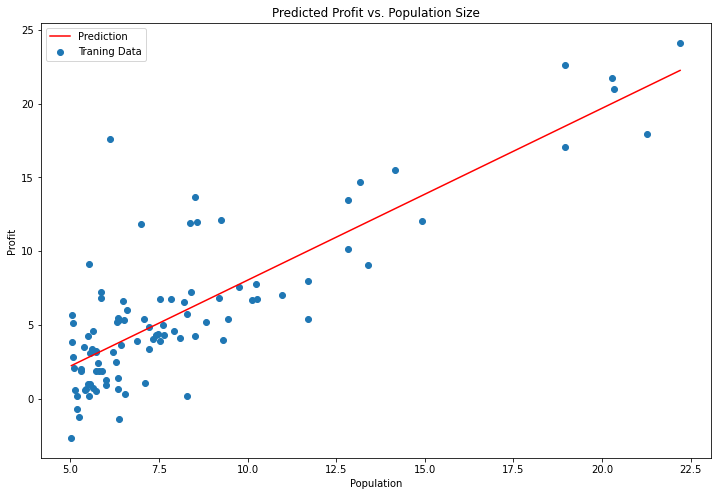

In [570]:
# 原始数据及拟合直线
x = np.linspace(data.Population.min(), data.Population.max(), 100)
f = g[0, 0] + (g[1, 0] * x)
fig, ax = plt.subplots(figsize=(12 ,8))
ax.plot(x, f, 'r', label='Prediction')
ax.scatter(data.Population, data.Profit, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_title('Predicted Profit vs. Population Size')
plt.show()

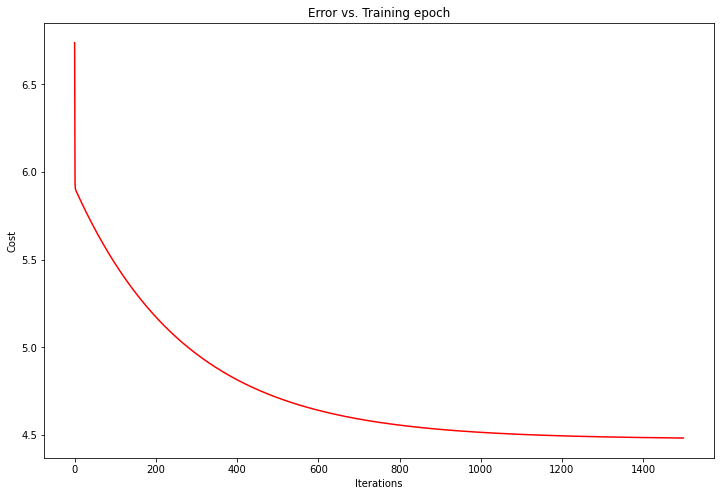

In [571]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1500), cost, 'r')
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.set_title("Error vs. Training epoch")
plt.show()

# 3 多变量线性回归

In [572]:
data2 = pd.read_csv("../吴恩达-机器学习/Andrew-NG-Meachine-Learning/machine-learning-ex1/ex1/ex1data2.txt", header=None, names=['Size', 'Bedrooms', 'Price'])
data2.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


## 3.1 标准化数据
最简单的方法是使用标准化，
$$ x - mean / std$$

In [573]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [574]:
data2 = normalize_feature(data2)
data2.head()

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


## 3.2 得到数据


In [575]:
data2.insert(0, 'Ones', 1)
data2.head(), data2.shape

(   Ones      Size  Bedrooms     Price
 0     1  0.130010 -0.223675  0.475747
 1     1 -0.504190 -0.223675 -0.084074
 2     1  0.502476 -0.223675  0.228626
 3     1 -0.735723 -1.537767 -0.867025
 4     1  1.257476  1.090417  1.595389,
 (47, 4))

In [576]:
num = data2.shape[1]
x = data2.iloc[:, 0:3]
y = data2.iloc[:, num - 1: num]
print(x.head()), print(y.head())
X2 = np.array(x)
y2 = np.array(y)
theta2 = np.zeros(3).reshape(3, 1)
x.shape, theta2.shape, y.shape

   Ones      Size  Bedrooms
0     1  0.130010 -0.223675
1     1 -0.504190 -0.223675
2     1  0.502476 -0.223675
3     1 -0.735723 -1.537767
4     1  1.257476  1.090417
      Price
0  0.475747
1 -0.084074
2  0.228626
3 -0.867025
4  1.595389


((47, 3), (3, 1), (47, 1))

## 3.3 运行梯度下降算法

In [577]:
g, cost = gradientDescent2(X2, y2, theta2, alpha, 1500)

g, g.shape , cost.shape

(array([[-9.37429803e-17],
        [ 8.84042349e-01],
        [-5.24551809e-02]]),
 (3, 1),
 (1500,))

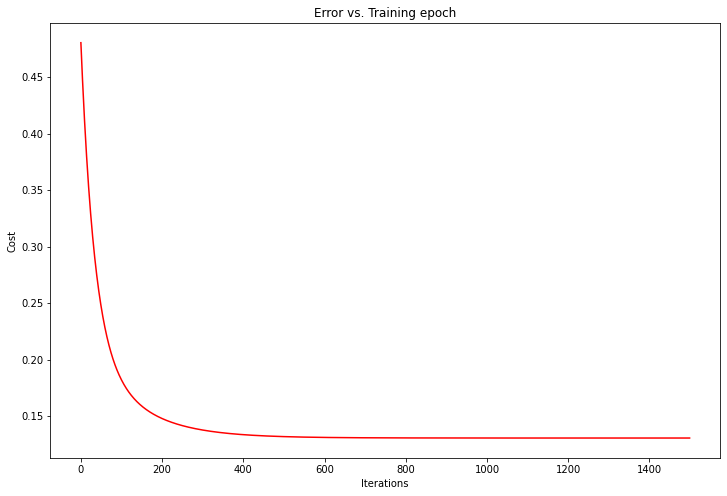

In [578]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1500), cost, 'r')
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.set_title("Error vs. Training epoch")
plt.show()

## 3.4 不同学习率

/var/folders/dq/_x9436w56md7jn43_4mzmhcr0000gn/T/ipykernel_45819/2776116780.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(range(iters), cost_data, 'r', label=alpha, color=colors[i])
/var/folders/dq/_x9436w56md7jn43_4mzmhcr0000gn/T/ipykernel_45819/2776116780.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(range(iters), cost_data, 'r', label=alpha, color=colors[i])
/var/folders/dq/_x9436w56md7jn43_4mzmhcr0000gn/T/ipykernel_45819/2776116780.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(range(iters), cost_data, 'r', label=alpha, color=colors[i])
/var/folders/dq/_x9436w56md7

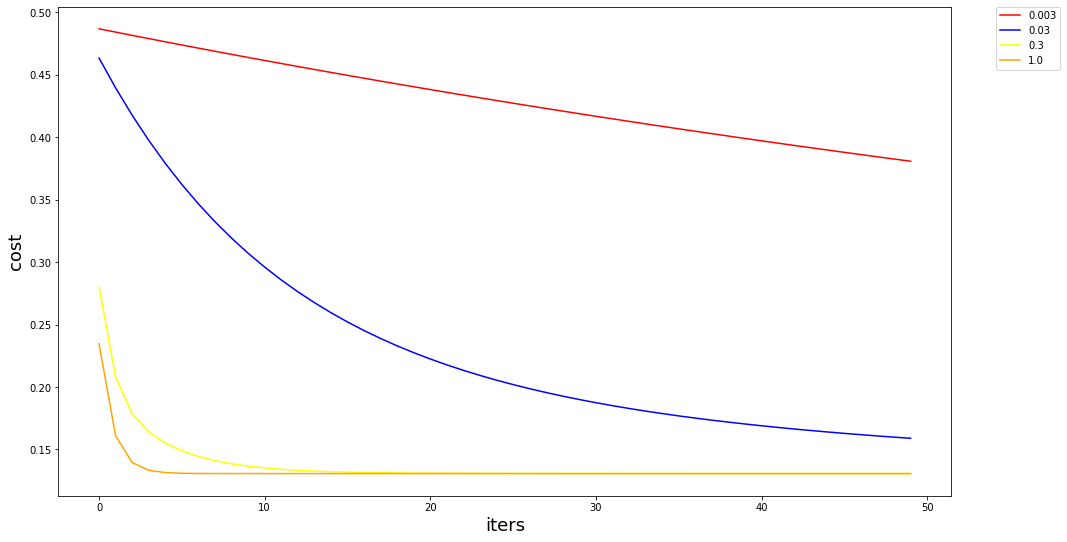

In [579]:
iters = 50
base = np.logspace(-1, -5, num =4)
base2 = [0.003, 0.03, 0.3,1 ]
colors = ['red', 'blue', 'yellow', 'orange']
# candidate = np.sort(np.concatenate((base2, base2 * 3)))
candidate = np.sort(base2)
base, candidate

fig, ax = plt.subplots(figsize=(16, 9))

i = 0
for alpha in candidate:
    _, cost_data = gradientDescent2(X2, y2, theta2, alpha, iters)
    ax.plot(range(iters), cost_data, 'r', label=alpha, color=colors[i])
    i = i + 1

ax.set_xlabel("iters", fontsize=18)
ax.set_ylabel("cost", fontsize=18)
ax.legend(bbox_to_anchor=(1.05,1), loc = 2, borderaxespad=0.)
plt.show()


## 3.5 正规方程

正规方程： 正规方程是通过求解下面的房产来使得代价函数最小的参数等。
$$
    \frac{\partial}{\partial\theta_j}J(\theta_j) = 0
$$
假设我们的训练集特征矩阵为X，并且我们的训练集结果为向量y，则利用正规方程解出向量$\theta$
$$
    \theta = \left(X^TX\right)^{(-1)}X^Ty
$$
正规方程：不需要选择学习率α，一次计算得出, 当特征数量n较大时则运算代价大，当n小于10000时还是可以接受的，只适用于线性模型。

In [580]:
A = np.dot(X.T, X)
B=inv(A)
print(B)

[[ 0.05662112 -0.00567561]
 [-0.00567561  0.00069556]]


In [581]:
def normalEquation(X, y): 
    """
    
    """
    A = np.dot(X.T, X)
    theta = np.dot(np.dot(inv(A), X.T), y)
    return theta

In [585]:
theta3 = normalEquation(X2, y2)

theta3

array([[-8.67361738e-17],
       [ 8.84765988e-01],
       [-5.31788197e-02]])

# 4. Pytorch 

In [596]:
import torch
print(X2.shape, y2.shape)
X2 = torch.Tensor(X2)
y2 = torch.Tensor(y2)
X2, y2

torch.Size([47, 3]) torch.Size([47, 1])


(tensor([[ 1.0000e+00,  1.3001e-01, -2.2368e-01],
         [ 1.0000e+00, -5.0419e-01, -2.2368e-01],
         [ 1.0000e+00,  5.0248e-01, -2.2368e-01],
         [ 1.0000e+00, -7.3572e-01, -1.5378e+00],
         [ 1.0000e+00,  1.2575e+00,  1.0904e+00],
         [ 1.0000e+00, -1.9732e-02,  1.0904e+00],
         [ 1.0000e+00, -5.8724e-01, -2.2368e-01],
         [ 1.0000e+00, -7.2188e-01, -2.2368e-01],
         [ 1.0000e+00, -7.8102e-01, -2.2368e-01],
         [ 1.0000e+00, -6.3757e-01, -2.2368e-01],
         [ 1.0000e+00, -7.6357e-02,  1.0904e+00],
         [ 1.0000e+00, -8.5674e-04, -2.2368e-01],
         [ 1.0000e+00, -1.3927e-01, -2.2368e-01],
         [ 1.0000e+00,  3.1173e+00,  2.4045e+00],
         [ 1.0000e+00, -9.2196e-01, -2.2368e-01],
         [ 1.0000e+00,  3.7664e-01,  1.0904e+00],
         [ 1.0000e+00, -8.5652e-01, -1.5378e+00],
         [ 1.0000e+00, -9.6222e-01, -2.2368e-01],
         [ 1.0000e+00,  7.6547e-01,  1.0904e+00],
         [ 1.0000e+00,  1.2965e+00,  1.0904e+00],


In [605]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

model = Model()
# criterion 标准yd 
criterion = torch.nn.MSELoss(size_average=False) # loss function
# optimizer 优化器    lr 学习率
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # optimizer
for epoch in range(50):
    y_pred = model(X2)
    # compute loss
    loss = criterion(y_pred, y2)
    print(epoch, loss)
    # gradient descent
    optimizer.zero_grad()
    # backward
    loss.backward()
    # 更新 weights
    optimizer.step()

0 tensor(64.5479, grad_fn=<MseLossBackward0>)
1 tensor(35.8901, grad_fn=<MseLossBackward0>)
2 tensor(27.1046, grad_fn=<MseLossBackward0>)
3 tensor(23.0117, grad_fn=<MseLossBackward0>)
4 tensor(20.4164, grad_fn=<MseLossBackward0>)
5 tensor(18.5368, grad_fn=<MseLossBackward0>)
6 tensor(17.1136, grad_fn=<MseLossBackward0>)
7 tensor(16.0203, grad_fn=<MseLossBackward0>)
8 tensor(15.1762, grad_fn=<MseLossBackward0>)
9 tensor(14.5234, grad_fn=<MseLossBackward0>)
10 tensor(14.0182, grad_fn=<MseLossBackward0>)
11 tensor(13.6270, grad_fn=<MseLossBackward0>)
12 tensor(13.3241, grad_fn=<MseLossBackward0>)
13 tensor(13.0896, grad_fn=<MseLossBackward0>)
14 tensor(12.9080, grad_fn=<MseLossBackward0>)
15 tensor(12.7673, grad_fn=<MseLossBackward0>)
16 tensor(12.6584, grad_fn=<MseLossBackward0>)
17 tensor(12.5741, grad_fn=<MseLossBackward0>)
18 tensor(12.5087, grad_fn=<MseLossBackward0>)
19 tensor(12.4582, grad_fn=<MseLossBackward0>)
20 tensor(12.4190, grad_fn=<MseLossBackward0>)
21 tensor(12.3887, grad

/usr/local/anaconda3/envs/dataScience/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
